## Detecting oneset of machine failure using anomaly detection

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>

<div style="text-align: right\"> Initial upload: 2020.1.19 </div>
<div style="text-align: right\"> Last update: 2020.1.19</div>

참고자료  
- https://github.com/animeshgoyal9/Detecting-Onset-of-Machine-Failure-using-Anomaly-Detection/blob/master/Anomaly%20Detection%20in%20Time%20Series.ipynb  
- https://www.kaggle.com/boltzmannbrain/nab  
- https://towardsdatascience.com/detecting-the-onset-of-machine-failure-using-anomaly-detection-techniques-d2f7a11eb809

Univariate time series 데이터의 이상탐지 방법 비고

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

In [2]:
colors = ["#00798c", "#d1495b", '#edae49', '#66a182', '#4a4a4a',
          '#1a508b', '#e3120b', '#c5a880', '#9F5F80', '#6F9EAF',
          '#0278ae','#F39233', '#A7C5EB', '#54E346', '#ABCE74',
        '#d6b0b1', '#58391c', '#cdd0cb', '#ffb396', '#6930c3']
sns.color_palette(colors[:10])

[(0.0, 0.4745098039215686, 0.5490196078431373),
 (0.8196078431372549, 0.28627450980392155, 0.3568627450980392),
 (0.9294117647058824, 0.6823529411764706, 0.28627450980392155),
 (0.4, 0.6313725490196078, 0.5098039215686274),
 (0.2901960784313726, 0.2901960784313726, 0.2901960784313726),
 (0.10196078431372549, 0.3137254901960784, 0.5450980392156862),
 (0.8901960784313725, 0.07058823529411765, 0.043137254901960784),
 (0.7725490196078432, 0.6588235294117647, 0.5019607843137255),
 (0.6235294117647059, 0.37254901960784315, 0.5019607843137255),
 (0.43529411764705883, 0.6196078431372549, 0.6862745098039216)]

### 1. 데이터 읽기

In [3]:
url = 'https://raw.githubusercontent.com/sguys99/datasets/master/'
df = pd.read_csv(url + 'machine_temperature_system_failure.csv')

In [4]:
df.head()

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836


In [5]:
df.shape

(22695, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22695 entries, 0 to 22694
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  22695 non-null  object 
 1   value      22695 non-null  float64
dtypes: float64(1), object(1)
memory usage: 354.7+ KB


데이터 타입 및 단위 조정

In [7]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [8]:
# 섭씨 온도로 수정
df['value'] = (df['value'] - 32) * 5/9

전체 데이터 시각화

Text(0.5, 1.0, 'Ambient temp')

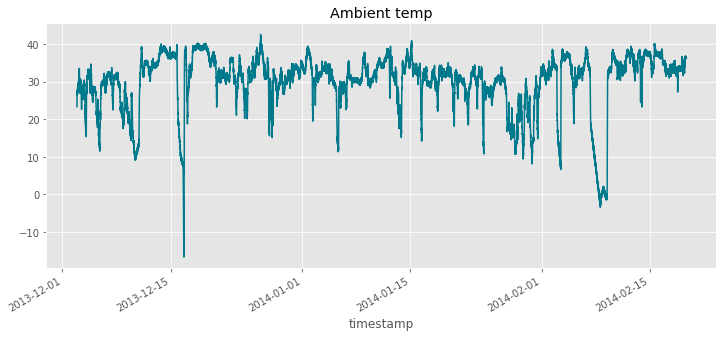

In [9]:
fig, ax = plt.subplots(figsize = (12, 5))
df.set_index('timestamp')['value'].plot(ax = ax, color = colors[0], label = 'temp')
plt.title('Ambient temp')

### 2. 특성공학

In [10]:
df['hours'] = df['timestamp'].dt.hour
df['daylight'] = ((df['hours']>=7) &(df['hours']<=22)).astype(int)
df['Day of week'] = df['timestamp'].dt.dayofweek
df['weekday'] = (df['Day of week'] < 5).astype(int)

outlier_fraction = 0.01

In [11]:
df.head()

,timestamp,value,hours,daylight,Day of week,weekday
0,2013-12-02 21:15:00,23.315179,21,1,0,1
1,2013-12-02 21:20:00,23.853268,21,1,0,1
2,2013-12-02 21:25:00,24.513423,21,1,0,1
3,2013-12-02 21:30:00,25.633726,21,1,0,1
4,2013-12-02 21:35:00,26.294353,21,1,0,1


In [12]:
# time with int to plot easily
df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

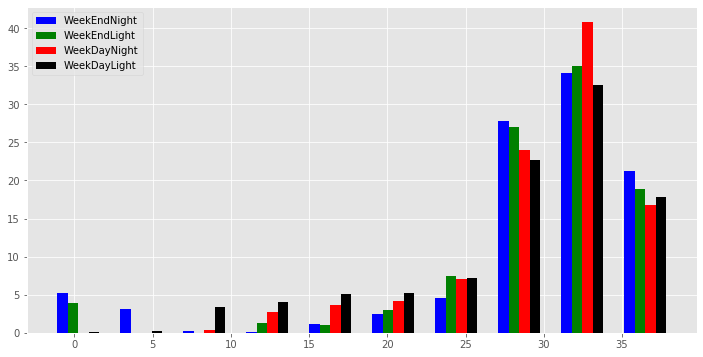

In [13]:
# creation of 4 distinct categories that seem useful (week end/day week & night/day)
df['categories'] = df['weekday']*2 + df['daylight']

a = df.loc[df['categories'] == 0, 'value']
b = df.loc[df['categories'] == 1, 'value']
c = df.loc[df['categories'] == 2, 'value']
d = df.loc[df['categories'] == 3, 'value']

fig, ax = plt.subplots(figsize = (12, 6))
a_heights, a_bins = np.histogram(a)
b_heights, b_bins = np.histogram(b, bins=a_bins)
c_heights, c_bins = np.histogram(c, bins=a_bins)
d_heights, d_bins = np.histogram(d, bins=a_bins)

width = (a_bins[1] - a_bins[0])/6

ax.bar(a_bins[:-1], a_heights*100/a.count(), width=width, facecolor='blue', label='WeekEndNight')
ax.bar(b_bins[:-1]+width, (b_heights*100/b.count()), width=width, facecolor='green', label ='WeekEndLight')
ax.bar(c_bins[:-1]+width*2, (c_heights*100/c.count()), width=width, facecolor='red', label ='WeekDayNight')
ax.bar(d_bins[:-1]+width*3, (d_heights*100/d.count()), width=width, facecolor='black', label ='WeekDayLight')

plt.legend()
plt.show()

- 평일 낮의 온도가 더 안정적이다.

In [14]:
df.head()

,timestamp,value,hours,daylight,Day of week,weekday,time_epoch,categories
0,2013-12-02 21:15:00,23.315179,21,1,0,1,13860189,3
1,2013-12-02 21:20:00,23.853268,21,1,0,1,13860192,3
2,2013-12-02 21:25:00,24.513423,21,1,0,1,13860195,3
3,2013-12-02 21:30:00,25.633726,21,1,0,1,13860198,3
4,2013-12-02 21:35:00,26.294353,21,1,0,1,13860201,3


### 3. Modeling

#### 2.1 Cluster 기반

군집화로 collective anomaly를 검출해본다. 몇개의 유용한 컬럼을 피처로 두고 군집으로 부터 멀리 떨어진 것을 이상치로 간주한다.

In [15]:
data =df[['value', 'hours', 'daylight', 'Day of week', 'weekday']]

스케일링

In [16]:
from sklearn.preprocessing import StandardScaler

In [17]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
data_scaled = pd.DataFrame(data =  data_scaled, columns=data.columns)

In [18]:
data_scaled.head()

,value,hours,daylight,Day of week,weekday
0,-0.869973,1.375415,0.709281,-1.484001,0.622342
1,-0.799515,1.375415,0.709281,-1.484001,0.622342
2,-0.713073,1.375415,0.709281,-1.484001,0.622342
3,-0.566379,1.375415,0.709281,-1.484001,0.622342
4,-0.479876,1.375415,0.709281,-1.484001,0.622342


차원축소

In [19]:
from sklearn.decomposition import PCA

In [20]:
pca = PCA(n_components = 2)
data_pca = pca.fit_transform(data_scaled)

In [21]:
data_pca

array([[-1.53185185, -1.54224484],
       [-1.52832155, -1.53585843],
       [-1.5239904 , -1.52802325],
       ...,
       [-0.73852009, -0.78036766],
       [-0.73516175, -0.77429231],
       [-0.73936428, -0.78189482]])

차원 축소된 것을 다시 스케일링

In [22]:
scaler = StandardScaler()
data_pca_scaled = scaler.fit_transform(data_pca)
data_pca_scaled = pd.DataFrame(data_pca_scaled, columns=['pca1', 'pca2'])

In [23]:
data_pca_scaled.head()

,pca1,pca2
0,-1.143708,-1.212546
1,-1.141072,-1.207525
2,-1.137839,-1.201365
3,-1.132351,-1.190911
4,-1.129115,-1.184746


Kmeans clustering : 엘보 메서드로 최적의 클러스터 찾기

In [24]:
from sklearn.cluster import KMeans

In [ ]:
inertia = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data_pca_scaled)
    inertia.append(kmeans.inertia_)

In [ ]:
fig, ax = plt.subplots(figsize = (12, 6))
ax = plt.plot(range(1, 20), inertia, color = colors[0])
ax = plt.axvline(14, linestyle = '--', color = 'red', alpha = 0.8)
plt.xlabel('# of clusters')
plt.ylabel('inertia')
plt.title('inertia vs # of clusters')
plt.show()

- 6개가 적절해 보이나 여기서는 원본과 동일하게 14개로 분류한다.

In [ ]:
kmeans = KMeans(n_clusters=14)
kmeans.fit(data_pca_scaled)

군집화 결과를 원본 df 컬럼에 저장

In [ ]:
df['cluster'] = kmeans.predict(data_pca_scaled)
df['pca1'] = data_pca_scaled['pca1']
df['pca2'] = data_pca_scaled['pca2']

In [ ]:
df.head()

In [ ]:
df['cluster'].value_counts()

군집화 결과 시각화

In [ ]:
#plot the different clusters with the 2 main features
fig, ax = plt.subplots(figsize = (6, 6))
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan'
          , 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey'}
ax.scatter(df['pca1'], df['pca2'], c=df["cluster"].apply(lambda x: colors[x]))
plt.show()

In [ ]:
kmeans.labels_

In [ ]:
kmeans.cluster_centers_

거리를 계산하는 함수

In [ ]:
# return Series of distance between each point and his distance with the closest centroid
def getDistanceByPoint(data, model):
    distance = []
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]]
        distance.append(np.linalg.norm(Xa-Xb))
    return distance

In [ ]:
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
distance = getDistanceByPoint(data_pca_scaled, kmeans)

In [ ]:
distance[:5]

In [ ]:
distance = pd.Series(distance)

전체 결과 중 outlier_fraction(0.01) 만큼은 아웃라이어로 간주한다.

In [ ]:
# oput lier 갯수
number_of_outliers = int(outlier_fraction*len(distance))

THreshold 설정 : number_of_outliers 만큼 값이 큰 순서대로 거리를 뽑은 후 그중에서 가장 작은 값으로 설정

In [ ]:
threshold = distance.nlargest(number_of_outliers).min()

In [ ]:
threshold

In [ ]:
# anomaly21 contain the anomaly result of method 2.1 Cluster (0:normal, 1:anomaly) 
df['anomaly21'] = (distance >= threshold).astype(int)

In [ ]:
fig, ax = plt.subplots(figsize = (6, 6))
colors = {0:'blue', 1:'red'}
ax.scatter(df['pca1'], df['pca2'], c=df["anomaly21"].apply(lambda x: colors[x]))
plt.show()

In [ ]:
df.head()

In [ ]:
fig, ax = plt.subplots(figsize = (12, 5))
anomaly = df.loc[df['anomaly21']==1, ['timestamp', 'value']]
df.set_index('timestamp')['value'].plot(ax =ax, color = colors[0])
ax.scatter(anomaly['timestamp'], anomaly['value'], color = colors[1])
plt.show()

In [ ]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly21'] == 0, 'value']
b = df.loc[df['anomaly21'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'], alpha = 0.5)
plt.legend()
plt.show()

- 군집방법은 저온부는 잘 감지하지만 고온부를 잘 감지 하지 못한다.

#### 2.2 카테고리화 + 가우시안

contextual anomaly 감지를 위해 데이터를 카테고리별로 나눈다. 해당 카테고리가 중요하다고 판단했다.

In [ ]:
# creation of 4 differents data set based on categories defined before
df_0 = df.loc[df['categories'] == 0, 'value']
df_1 = df.loc[df['categories'] == 1, 'value']
df_2 = df.loc[df['categories'] == 2, 'value']
df_3 = df.loc[df['categories'] == 3, 'value']

각 카테고리결 데이터 분포 확인

In [ ]:
# plot the temperature repartition by categories
fig, axs = plt.subplots(2,2)
df_0.hist(ax=axs[0,0],bins=32)
df_1.hist(ax=axs[0,1],bins=32)
df_2.hist(ax=axs[1,0],bins=32)
df_3.hist(ax=axs[1,1],bins=32)

Eliptic Envelope 구현하기 : 정규 분포를 이용하여 데이터 분포에 타원을 그림. 
타원에서 벗어날수록 outlier임  
contamination의 비율을 기준으로 비율보다 낮은 값을 검출한다.  
+1 이면 boundary 안에 들어온 값으로 정상 데이터  
-1 이면 outlier로 간주

In [ ]:
from sklearn.covariance import EllipticEnvelope

In [ ]:
envelope = EllipticEnvelope(contamination=outlier_fraction)

In [ ]:
X_train = df_0.values.reshape(-1, 1)
envelope.fit(X_train)
df_0 = pd.DataFrame(df_0)
df_0['deviation'] = envelope.decision_function(X_train)
df_0['anomaly'] = envelope.predict(X_train)

In [ ]:
df_0.head()

In [ ]:
envelope = EllipticEnvelope(contamination=outlier_fraction)
X_train = df_1.values.reshape(-1, 1)
envelope.fit(X_train)
df_1 = pd.DataFrame(df_1)
df_1['deviation'] = envelope.decision_function(X_train)
df_1['anomaly'] = envelope.predict(X_train)

In [ ]:
envelope = EllipticEnvelope(contamination=outlier_fraction)
X_train = df_2.values.reshape(-1, 1)
envelope.fit(X_train)
df_2 = pd.DataFrame(df_2)
df_2['deviation'] = envelope.decision_function(X_train)
df_2['anomaly'] = envelope.predict(X_train)

In [ ]:
envelope = EllipticEnvelope(contamination=outlier_fraction)
X_train = df_3.values.reshape(-1, 1)
envelope.fit(X_train)
df_3 = pd.DataFrame(df_3)
df_3['deviation'] = envelope.decision_function(X_train)
df_3['anomaly'] = envelope.predict(X_train)

In [ ]:
# plot the temperature repartition by categories with anomalies
a0 = df_0.loc[df_0['anomaly'] == 1, 'value']
b0 = df_0.loc[df_0['anomaly'] == -1, 'value']

a1 = df_1.loc[df_1['anomaly'] == 1, 'value']
b1 = df_1.loc[df_1['anomaly'] == -1, 'value']

a2 = df_2.loc[df_2['anomaly'] == 1, 'value']
b2 = df_2.loc[df_2['anomaly'] == -1, 'value']

a3 = df_3.loc[df_3['anomaly'] == 1, 'value']
b3 = df_3.loc[df_3['anomaly'] == -1, 'value']

fig, axs = plt.subplots(2,2, figsize = (10, 8))
axs[0,0].hist([a0,b0], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,1].hist([a1,b1], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,0].hist([a2,b2], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,1].hist([a3,b3], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,0].set_title("WeekEndNight")
axs[0,1].set_title("WeekEndLight")
axs[1,0].set_title("WeekDayNight")
axs[1,1].set_title("WeekDayLight")
plt.legend()
plt.show()

In [ ]:
df.head()

In [ ]:
# add the data to the main 
df_class = pd.concat([df_0, df_1, df_2, df_3])
df['anomaly22'] = df_class['anomaly']
df['anomaly22'] = np.array(df['anomaly22'] == -1).astype(int)

In [ ]:
df.head()

In [ ]:
fig, ax = plt.subplots(figsize = (12, 5))
anomaly = df.loc[df['anomaly22']==1, ['timestamp', 'value']]
df.set_index('timestamp')['value'].plot(ax =ax, color = colors[0])
ax.scatter(anomaly['timestamp'], anomaly['value'], color = colors[1])
plt.show()

In [ ]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly22'] == 0, 'value']
b = df.loc[df['anomaly22'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'], alpha = 0.5)
plt.legend()
plt.show()

#### 2.3 Cluster + Gaussian  
2.2와 유사하지만 그룹을 달리해서 실시

#### 2.4 Isolation Forest  
고차원 데이터에 유용

In [ ]:
data = df[['value', 'hours', 'daylight', 'Day of week', 'weekday']]

In [ ]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
data_scaled = pd.DataFrame(data =  data_scaled, columns=data.columns)

In [ ]:
from sklearn.ensemble import IsolationForest

In [ ]:
model = IsolationForest(contamination=outlier_fraction)
model.fit(data_scaled)

In [ ]:
df['anomaly25'] = model.predict(data_scaled)
df['anomaly25'] = df['anomaly25'].map( {1: 0, -1: 1} )

In [ ]:
df.head()

In [ ]:
print(df['anomaly25'].value_counts())

In [ ]:
fig, ax = plt.subplots(figsize = (12, 5))
anomaly = df.loc[df['anomaly25']==1, ['timestamp', 'value']]
df.set_index('timestamp')['value'].plot(ax =ax, color = colors[0])
ax.scatter(anomaly['timestamp'], anomaly['value'], color = colors[1])
plt.show()

In [ ]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly25'] == 0, 'value']
b = df.loc[df['anomaly25'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'], alpha = 0.5)
plt.legend()
plt.show()

#### 2.6 One class SVM

학습데이터에 확인되지 않은 novelty 검출에 효과적. multimodal 데이터에 잘동작

In [ ]:
data = df[['value', 'hours', 'daylight', 'Day of week', 'weekday']]

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
data_scaled = pd.DataFrame(data =  data_scaled, columns=data.columns)

In [ ]:
from sklearn.svm import OneClassSVM

In [ ]:
model =  OneClassSVM(nu=0.95 * outlier_fraction) #nu=0.95 * outliers_fraction  + 0.05
model.fit(data_scaled)

In [ ]:
df['anomaly26'] = model.predict(data_scaled)
df['anomaly26'] = df['anomaly26'].map( {1: 0, -1: 1} )

In [ ]:
print(df['anomaly26'].value_counts())

In [ ]:
fig, ax = plt.subplots(figsize = (12, 5))
anomaly = df.loc[df['anomaly26']==1, ['timestamp', 'value']]
df.set_index('timestamp')['value'].plot(ax =ax, color = colors[0])
ax.scatter(anomaly['timestamp'], anomaly['value'], color = colors[1])
plt.show()

In [ ]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly26'] == 0, 'value']
b = df.loc[df['anomaly26'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'], alpha = 0.5)
plt.legend()
plt.show()

#### 2.7 LSTM
sequential anomaly에 유용. 시퀀스를 입력으로 받아 다음 스텝의 값을 예측함. 다음 데이터 포인트가 예측결과와 차이가 나면 이상으로 간주  
입력 시퀀스의 사이즈와 예측구간의 사이즈가 중요한 파라미터임(기준거리 포함)

여기서는 50개의 이전 시퀀스 입력을 받아서 다음 1개를 예측하는 모델을 생성함

In [ ]:
data = df[['value', 'hours', 'daylight', 'Day of week', 'weekday']]

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
data_scaled = pd.DataFrame(data =  data_scaled, columns=data.columns)

학습 시험데이터 구분

In [ ]:
prediction_time = 1 
testdatasize = 1000
unroll_length = 50
testdatacut = testdatasize + unroll_length  + 1

In [ ]:
-prediction_time-testdatacut

In [ ]:
X_train = data_scaled[0: -prediction_time-testdatacut] # 뒤에서 카운팅해서 1052샘플 앞까지
y_train = data_scaled[prediction_time: - testdatacut]['value'] # 1step 뒤의 값   

X_test = data_scaled[0 -testdatacut: -prediction_time]
y_test = data_scaled[prediction_time - testdatacut:]['value']

In [ ]:
#unroll: create sequence of 50 previous data points for each data points
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

In [ ]:
# adapt the datasets for the sequence data shape
X_train = unroll(X_train.values,unroll_length)
X_test  = unroll(X_test.values,unroll_length)
y_train = y_train.values[-X_train.shape[0]:]
y_test  = y_test.values[-X_test.shape[0]:]

In [ ]:
# see the shape
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

모델 만들기

In [ ]:
from tensorflow.keras.layers import LSTM, Dense, Activation, Dropout
from tensorflow.keras.models import Sequential

In [ ]:
model = Sequential()

model.add(LSTM(units = 50, input_shape = X_train.shape[1:], return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 100, return_sequences = False))
model.add(Dropout(0.2))
model.add(Dense(units = 1))
model.add(Activation('linear'))

In [ ]:
model.compile(loss = 'mse', optimizer='rmsprop')

In [ ]:
model.fit(X_train, y_train, batch_size=3028, epochs=30, validation_split=0.1)

In [ ]:
diff=[]
ratio=[]
preds = model.predict(X_test)

In [ ]:
preds.shape

In [ ]:
for i in range(len(y_test)):
    pred = preds[i][0]
    ratio.append((y_test[i]/pred)-1)
    diff.append(abs(y_test[i]-pred))

In [ ]:
fig, ax = plt.subplots(figsize = (12, 5))
ax.plot(preds, color = 'red', label = 'prediction')
ax.plot(y_test, color = 'blue', label = 'y_test')
plt.legend(loc = 'upper left')
plt.show()

In [ ]:
diff = pd.Series(diff)
number_of_outliers = int(outlier_fraction*len(diff))
threshold = diff.nlargest(number_of_outliers).min()

In [ ]:
diff >= threshold

In [ ]:
test = (diff >= threshold).astype(int)

In [ ]:
# 학습에 사용되지 않은 부분은 정상으로 설정 (0)
complement = pd.Series(0, index=np.arange(len(data_scaled)-testdatasize))

In [ ]:
df['anomaly27'] = complement.append(test, ignore_index='True')

In [ ]:
print(df['anomaly27'].value_counts())

In [ ]:
fig, ax = plt.subplots(figsize = (12, 5))
anomaly = df.loc[df['anomaly27']==1, ['timestamp', 'value']]
df.set_index('timestamp')['value'].plot(ax =ax, color = colors[0])
ax.scatter(anomaly['timestamp'], anomaly['value'], color = colors[1])
plt.show()

In [ ]:
# visualisation of anomaly with temperature repartition (viz 2)
a = df.loc[df['anomaly27'] == 0, 'value']
b = df.loc[df['anomaly27'] == 1, 'value']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'], alpha = 0.5)
plt.legend()
plt.show()

### 3. 결론

위 경우에서는 OCSVM의 성능이 가장우수